## Setup

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [4]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [5]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [6]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [35]:
%%R 

# this code is incomplete, refer to example notebooks
# and use chat gpt for help getting census variables
md_census_data <- get_acs(geography="tract",
                          state='MD',
                          county=c("005", "510"),
                          variables=c(
                              mean_hours_total = "B23020_001",
                              mean_hours_male = "B23020_002",
                              mean_hours_female = "B23020_003",
                              pop = "B07007_001",
                              native_born = "B07007_002",
                              foreign_born = "B07007_003",
                              naturalized = "B07007_004",
                              not_citizen = "B07007_005"
                          ),
                           year=2021,
                           survey="acs5",
                           geometry=TRUE)

md_census_data


Simple feature collection with 3344 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -76.89556 ymin: 39.19541 xmax: -76.32143 ymax: 39.7212
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                        NAME          variable
1  24510160300 Census Tract 1603, Baltimore city, Maryland               pop
2  24510160300 Census Tract 1603, Baltimore city, Maryland       native_born
3  24510160300 Census Tract 1603, Baltimore city, Maryland      foreign_born
4  24510160300 Census Tract 1603, Baltimore city, Maryland       naturalized
5  24510160300 Census Tract 1603, Baltimore city, Maryland       not_citizen
6  24510160300 Census Tract 1603, Baltimore city, Maryland  mean_hours_total
7  24510160300 Census Tract 1603, Baltimore city, Maryland   mean_hours_male
8  24510160300 Census Tract 1603, Baltimore city, Maryland mean_hours_female
9  24510020100  Census Tract 201, Baltimore city, Maryland               pop
10 2451002

Getting data from the 2017-2021 5-year ACS
Using FIPS code '24' for state 'MD'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [37]:
%%R 

md_census_data <- md_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

md_census_data

Simple feature collection with 418 features and 18 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -76.89556 ymin: 39.19541 xmax: -76.32143 ymax: 39.7212
Geodetic CRS:  NAD83
# A tibble: 418 × 19
   GEOID       NAME                   geometry pop_estimate native_born_estimate
   <chr>       <chr>        <MULTIPOLYGON [°]>        <dbl>                <dbl>
 1 24510160300 Cens… (((-76.64612 39.30311, -…         1578                 1560
 2 24510020100 Cens… (((-76.59047 39.29168, -…         1738                 1512
 3 24005402602 Cens… (((-76.78897 39.36909, -…         2027                 1819
 4 24510190300 Cens… (((-76.64696 39.28815, -…         2234                 2123
 5 24510271801 Cens… (((-76.68761 39.34941, -…         2087                 1820
 6 24510272007 Cens… (((-76.71152 39.36576, -…         3629                 3154
 7 24510240200 Cens… (((-76.60923 39.27899, -…         2543                 2321
 8 24510270903 Cens… (((-76.59973 39.34515, -…   

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [39]:
%%R 

# your code here. refer to example notebooks for help
md_census_data <- md_census_data %>%
    mutate(
        pct_native_born = native_born_estimate / pop_estimate,
        pct_foreign_born = foreign_born_estimate / pop_estimate,
        pct_naturalized = naturalized_estimate / pop_estimate,
        pct_not_citizen = not_citizen_estimate / pop_estimate
    )
md_census_data

Simple feature collection with 418 features and 22 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -76.89556 ymin: 39.19541 xmax: -76.32143 ymax: 39.7212
Geodetic CRS:  NAD83
# A tibble: 418 × 23
   GEOID       NAME                   geometry pop_estimate native_born_estimate
 * <chr>       <chr>        <MULTIPOLYGON [°]>        <dbl>                <dbl>
 1 24510160300 Cens… (((-76.64612 39.30311, -…         1578                 1560
 2 24510020100 Cens… (((-76.59047 39.29168, -…         1738                 1512
 3 24005402602 Cens… (((-76.78897 39.36909, -…         2027                 1819
 4 24510190300 Cens… (((-76.64696 39.28815, -…         2234                 2123
 5 24510271801 Cens… (((-76.68761 39.34941, -…         2087                 1820
 6 24510272007 Cens… (((-76.71152 39.36576, -…         3629                 3154
 7 24510240200 Cens… (((-76.60923 39.27899, -…         2543                 2321
 8 24510270903 Cens… (((-76.59973 39.34515, -…   

In [79]:
%%R
# Look at the data before pivoting
head(md_census_data)


Simple feature collection with 6 features and 22 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -76.79125 ymin: 39.27949 xmax: -76.58706 ymax: 39.37193
Geodetic CRS:  NAD83
# A tibble: 6 × 23
  GEOID       NAME                    geometry pop_estimate native_born_estimate
  <chr>       <chr>         <MULTIPOLYGON [°]>        <dbl>                <dbl>
1 24510160300 Censu… (((-76.64612 39.30311, -…         1578                 1560
2 24510020100 Censu… (((-76.59047 39.29168, -…         1738                 1512
3 24005402602 Censu… (((-76.78897 39.36909, -…         2027                 1819
4 24510190300 Censu… (((-76.64696 39.28815, -…         2234                 2123
5 24510271801 Censu… (((-76.68761 39.34941, -…         2087                 1820
6 24510272007 Censu… (((-76.71152 39.36576, -…         3629                 3154
# ℹ 18 more variables: foreign_born_estimate <dbl>, naturalized_estimate <dbl>,
#   not_citizen_estimate <dbl>, mean_hours_total_esti

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 5 rows containing non-finite outside the scale range (`stat_bin()`). 



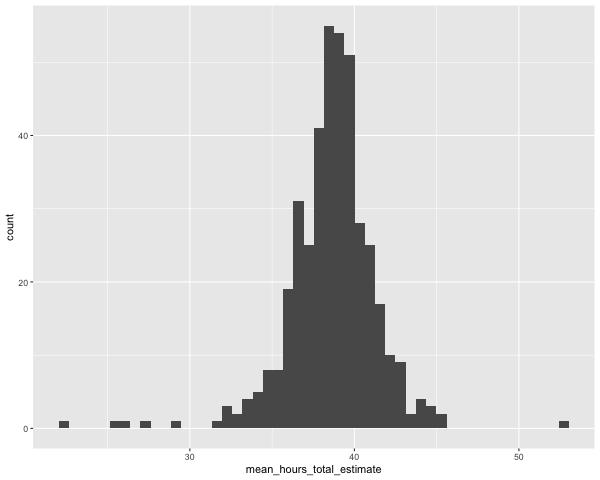

In [33]:
%%R -w 600

ggplot(md_census_data) +
    aes(x=mean_hours_total_estimate) +
    geom_histogram(bins=50)


# your code here. refer to example notebooks for help


In [49]:
%%R

md_census_long <- md_census_data %>%
    pivot_longer(cols = c(pct_native_born, pct_foreign_born, pct_naturalized, pct_not_citizen),
                 names_to = "citizenship_category",
                 values_to = "citizenship__category_pct")
md_census_long

Simple feature collection with 1672 features and 20 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -76.89556 ymin: 39.19541 xmax: -76.32143 ymax: 39.7212
Geodetic CRS:  NAD83
# A tibble: 1,672 × 21
   GEOID       NAME                   geometry pop_estimate native_born_estimate
   <chr>       <chr>        <MULTIPOLYGON [°]>        <dbl>                <dbl>
 1 24510160300 Cens… (((-76.64612 39.30311, -…         1578                 1560
 2 24510160300 Cens… (((-76.64612 39.30311, -…         1578                 1560
 3 24510160300 Cens… (((-76.64612 39.30311, -…         1578                 1560
 4 24510160300 Cens… (((-76.64612 39.30311, -…         1578                 1560
 5 24510020100 Cens… (((-76.59047 39.29168, -…         1738                 1512
 6 24510020100 Cens… (((-76.59047 39.29168, -…         1738                 1512
 7 24510020100 Cens… (((-76.59047 39.29168, -…         1738                 1512
 8 24510020100 Cens… (((-76.59047 39.29168, -…

In [52]:
%%R

colnames(md_census_long)


 [1] "GEOID"                      "NAME"                      
 [3] "geometry"                   "pop_estimate"              
 [5] "native_born_estimate"       "foreign_born_estimate"     
 [7] "naturalized_estimate"       "not_citizen_estimate"      
 [9] "mean_hours_total_estimate"  "mean_hours_male_estimate"  
[11] "mean_hours_female_estimate" "pop_moe"                   
[13] "native_born_moe"            "foreign_born_moe"          
[15] "naturalized_moe"            "not_citizen_moe"           
[17] "mean_hours_total_moe"       "mean_hours_male_moe"       
[19] "mean_hours_female_moe"      "citizenship_category"      
[21] "citizenship__category_pct" 


## I made the below charts, but I realized they were all the same for each citizenship category, so I guess CensusReporter doesn't disaggregate the work hours indicator by migration status.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 20 rows containing non-finite outside the scale range (`stat_bin()`). 



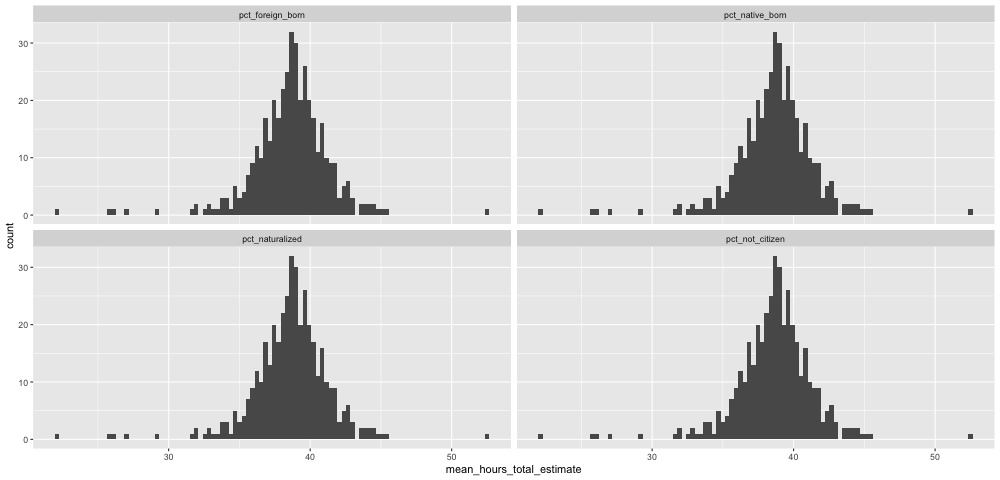

In [65]:
%%R -w 1000

ggplot(md_census_long) +
    aes(x=mean_hours_total_estimate) +
    geom_histogram(bins=100) +
    facet_wrap(~citizenship_category)



In [81]:
%%R

md_census_long %>%
  group_by(citizenship_category) %>%
  summarise(mean_hours = mean(mean_hours_total_estimate, na.rm = TRUE))

Simple feature collection with 4 features and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -76.89556 ymin: 39.19541 xmax: -76.32143 ymax: 39.7212
Geodetic CRS:  NAD83
# A tibble: 4 × 3
  citizenship_category mean_hours                                       geometry
  <chr>                     <dbl>                             <MULTIPOLYGON [°]>
1 pct_foreign_born           38.6 (((-76.38693 39.24921, -76.38494 39.24299, -7…
2 pct_native_born            38.6 (((-76.38693 39.24921, -76.38494 39.24299, -7…
3 pct_naturalized            38.6 (((-76.38693 39.24921, -76.38494 39.24299, -7…
4 pct_not_citizen            38.6 (((-76.38693 39.24921, -76.38494 39.24299, -7…


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 20 rows containing missing values or values outside the scale range
(`geom_point()`). 



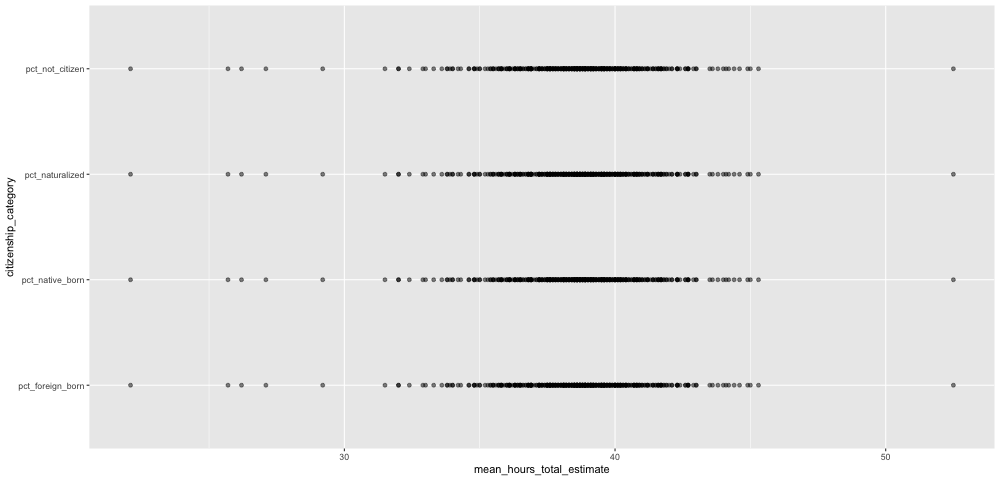

In [67]:
%%R -w 1000

ggplot(md_census_long) +
    aes(x=mean_hours_total_estimate, y=citizenship_category) +
    geom_point(alpha=0.5) 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 20 rows containing non-finite outside the scale range
(`stat_boxplot()`). 



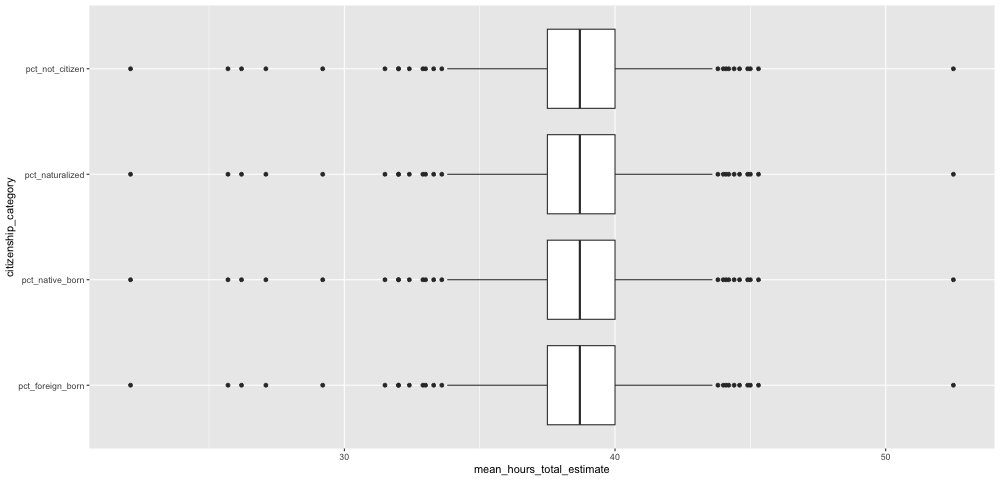

In [68]:
%%R -w 1000

ggplot(md_census_long) +
    aes(x=mean_hours_total_estimate, y=citizenship_category) +
    geom_boxplot()


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 20 rows containing missing values or values outside the scale range
(`geom_point()`). 



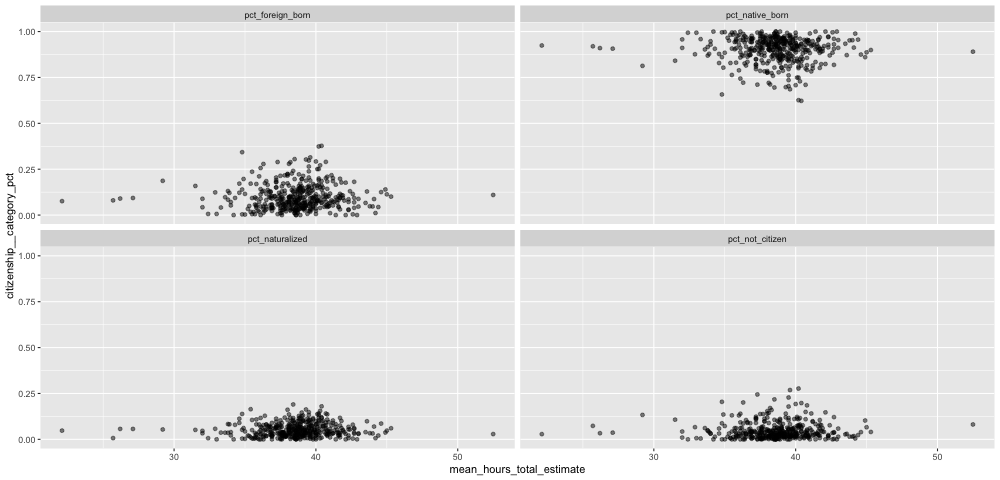

In [77]:
%%R -w 1000

ggplot(md_census_long) +
    aes(x=mean_hours_total_estimate, y=citizenship__category_pct) +
    geom_point(alpha=0.5) +
    facet_wrap(~citizenship_category)

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

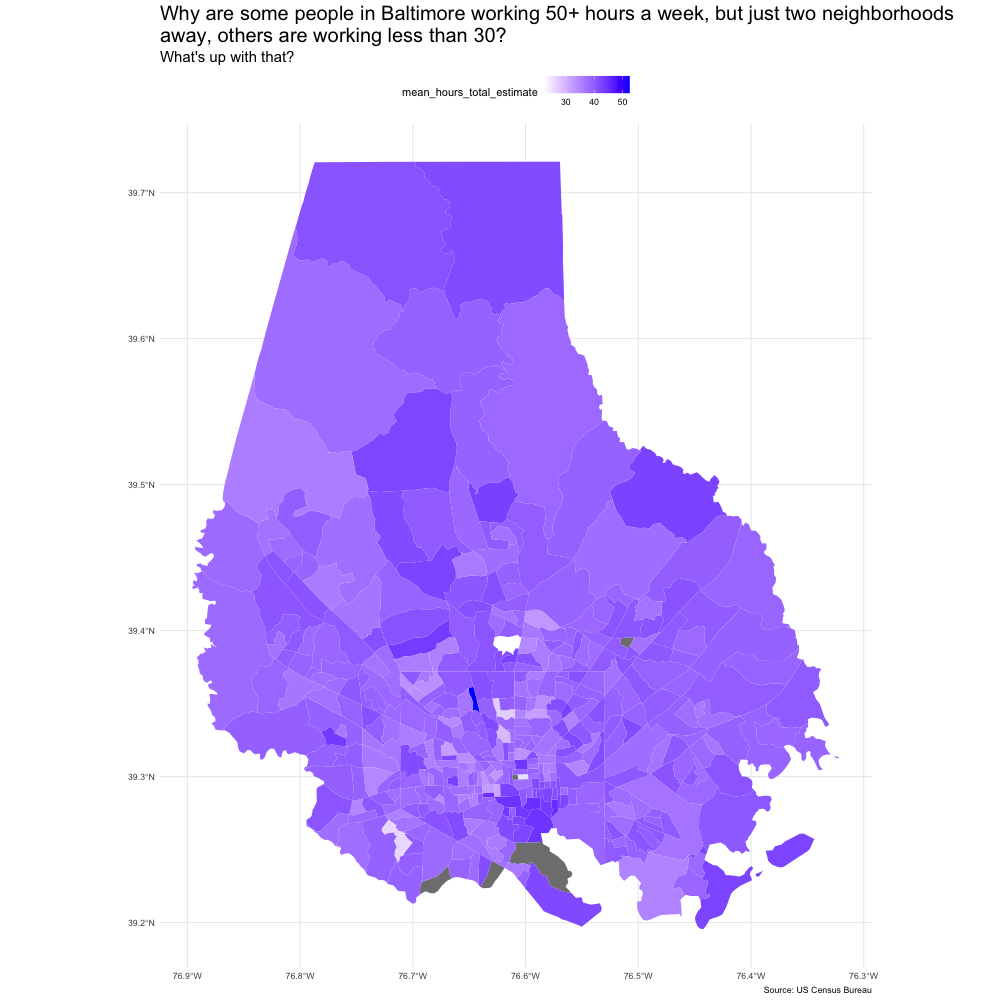

In [89]:
%%R -w 1000 -h 1000

md_census_data %>%
  ggplot(aes(fill = mean_hours_total_estimate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="blue") + 
  theme_minimal() +
  labs(
    title = "Why are some people in Baltimore working 50+ hours a week, but just two neighborhoods \naway, others are working less than 30?",
    subtitle = "What's up with that?",
    caption = "Source: US Census Bureau"
  ) +
  theme(
    #make title and subitle bigger
    plot.title = element_text(size = 20),
    plot.subtitle = element_text(size = 15),
    # move legend to top
    legend.position = "top"
  )

#ggsave("baltimore_workhours.png", width = 10, height = 10, units = "in", dpi = 300, scale = 1.5)